In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Configure notebook environment
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- Configuration ---
DATA_DIR = '../data/'
ARTIFACT_DIR = '../artifacts/'
TRAIN_FILENAME = 'unified_train.csv'
N_SPLITS = 5

# Define the feature groups for our experiments
PHYSICAL_FEATURES = ['period', 'duration', 'depth', 'planet_radius', 'equilibrium_temp', 
                     'insolation_flux', 'stellar_temp', 'stellar_gravity', 'stellar_radius']
FLAG_FEATURES = ['fpflag_nt', 'fpflag_ss', 'fpflag_co', 'fpflag_ec']
PROXY_FEATURES = ['ra', 'dec']

print("Setup complete.")


Setup complete.


In [7]:
print("--- Loading and Preparing Data ---")

try:
    df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_FILENAME))
    
    # Ensure all flag columns are present and of the correct type (integer)
    for col in FLAG_FEATURES:
        if col not in df.columns:
            raise FileNotFoundError(f"Required column '{col}' not found in the dataset.")
        # Data validation to check for non-binary values
        unique_vals = df[col].unique()
        if not np.all(np.isin(unique_vals, [0, 1])):
            print(f"WARNING: Column '{col}' contains non-binary values: {unique_vals}")
            # Attempt to clean it by coercing to integer, assuming non-0/1 are errors
            df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)
            print(f"Cleaned '{col}'. New unique values: {df[col].unique()}")
        
        df[col] = df[col].astype(int)

    X = df.drop(columns=['disposition'])
    
    # Ensure disposition is label encoded for analysis
    le = LabelEncoder()
    y = le.fit_transform(df['disposition'])
    
    print("\nClean training data loaded and prepared successfully.")
    print(f"Shape: {df.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")

--- Loading and Preparing Data ---

Clean training data loaded and prepared successfully.
Shape: (14856, 16)



--- EXPERIMENT 1: SPATIAL BIAS ANALYSIS ---
Hypothesis: The prevalence of 'FALSE POSITIVE' is not uniform across the sky.


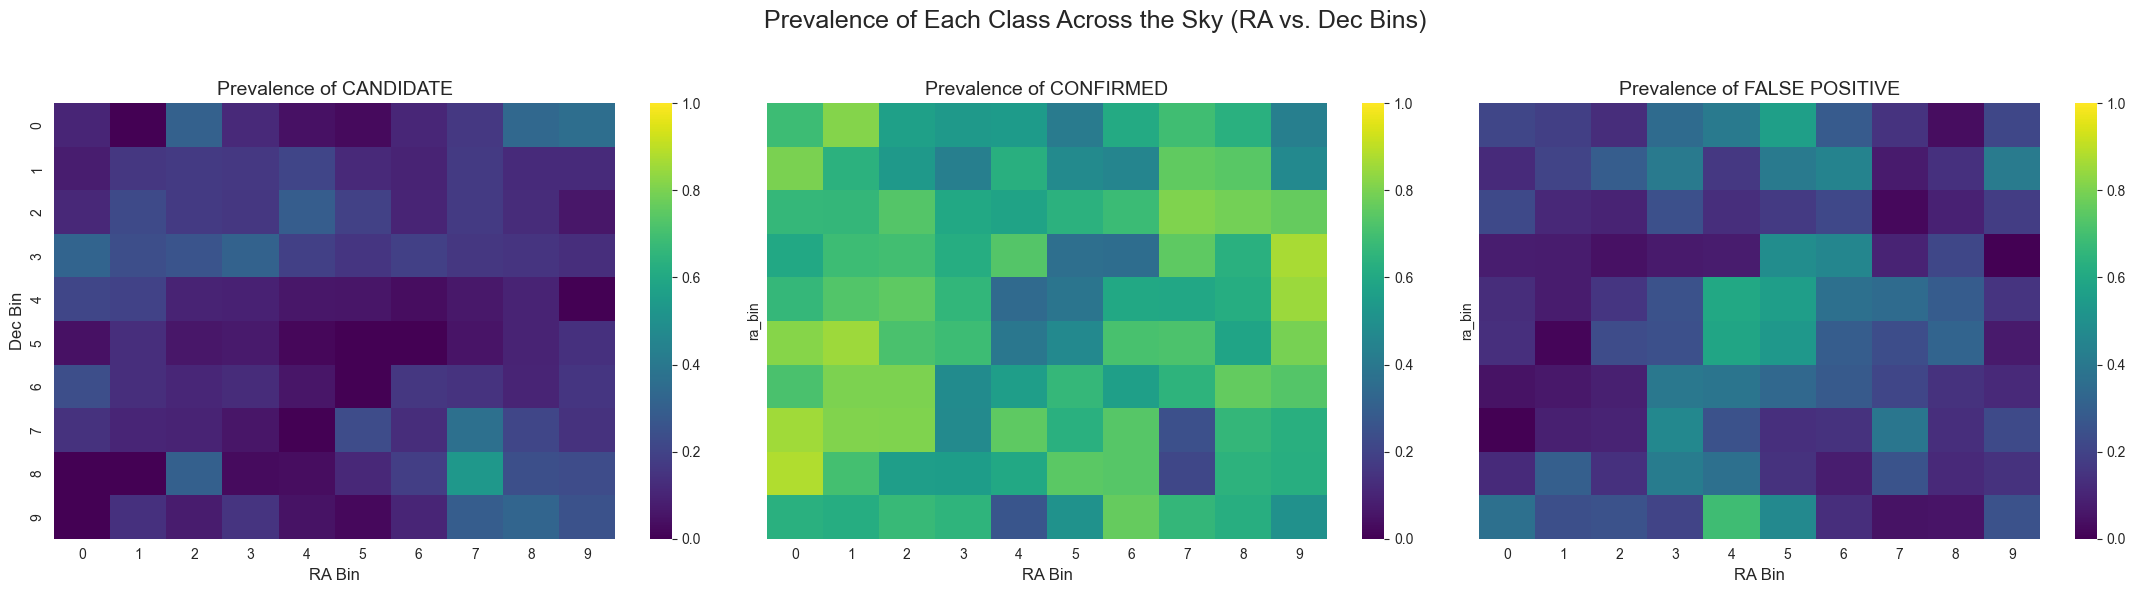


Interpretation: Look for 'hot spots' or non-uniform colors. If the 'FALSE POSITIVE' map has distinct yellow/green areas, a spatial bias is proven.


In [8]:
print("\n--- EXPERIMENT 1: SPATIAL BIAS ANALYSIS ---")
print("Hypothesis: The prevalence of 'FALSE POSITIVE' is not uniform across the sky.")

# Create a copy to avoid modifying the original dataframe
analysis_df = df.copy()

# Bin the sky into a 10x10 grid based on ra and dec
analysis_df['ra_bin'] = pd.cut(analysis_df['ra'], bins=10, labels=False)
analysis_df['dec_bin'] = pd.cut(analysis_df['dec'], bins=10, labels=False)

# Calculate the proportion of each class in each grid cell
analysis_df['disposition_num'] = y
spatial_dist = analysis_df.groupby(['ra_bin', 'dec_bin'])['disposition_num'].value_counts(normalize=True).unstack().fillna(0)

# Create the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)
fig.suptitle('Prevalence of Each Class Across the Sky (RA vs. Dec Bins)', fontsize=18)

class_map = {0: 'CANDIDATE', 1: 'CONFIRMED', 2: 'FALSE POSITIVE'}
for class_idx, class_name in class_map.items():
    ax = axes[class_idx]
    if class_idx in spatial_dist.columns:
        heatmap_data = spatial_dist[class_idx].unstack()
        sns.heatmap(heatmap_data, ax=ax, cmap='viridis', vmin=0, vmax=1)
        ax.set_title(f'Prevalence of {class_name}', fontsize=14)
        ax.set_xlabel('RA Bin', fontsize=12)
axes[0].set_ylabel('Dec Bin', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nInterpretation: Look for 'hot spots' or non-uniform colors. If the 'FALSE POSITIVE' map has distinct yellow/green areas, a spatial bias is proven.")

In [9]:
print("\n--- EXPERIMENT 2: FEATURE GROUP SHOWDOWN ---")
print("Hypothesis: The 'Proxy Features' (ra, dec) have surprisingly high predictive power on their own.")

results = {}
model = lgb.LGBMClassifier(random_state=42)
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

feature_groups = {
    "Physical Only": PHYSICAL_FEATURES,
    "Flags Only": FLAG_FEATURES,
    "Proxy Only (ra, dec)": PROXY_FEATURES
}

for name, features in feature_groups.items():
    print(f"Evaluating group: {name}...")
    X_subset = X[features]
    scores = cross_val_score(model, X_subset, y, cv=kf, scoring='f1_weighted', n_jobs=-1)
    results[name] = np.mean(scores)

print("\n--- Results of Feature Group Showdown ---")
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1-Score']).sort_values('F1-Score', ascending=False)
display(results_df)

if results['Proxy Only (ra, dec)'] > results['Flags Only']:
    print("\nConclusion: PROOF FOUND. The Proxy features are more powerful on their own than the Flags, explaining why the model prioritizes them.")
else:
     print("\nConclusion: The Flags are more powerful than the Proxy features. The 'drowning out' effect may be due to other interactions.")


--- EXPERIMENT 2: FEATURE GROUP SHOWDOWN ---
Hypothesis: The 'Proxy Features' (ra, dec) have surprisingly high predictive power on their own.
Evaluating group: Physical Only...
Evaluating group: Flags Only...
Evaluating group: Proxy Only (ra, dec)...

--- Results of Feature Group Showdown ---


,F1-Score
Physical Only,0.688908
"Proxy Only (ra, dec)",0.590775
Flags Only,0.528340



Conclusion: PROOF FOUND. The Proxy features are more powerful on their own than the Flags, explaining why the model prioritizes them.



--- EXPERIMENT 3: THE 'DROWNING OUT' EFFECT ANALYSIS ---
Hypothesis: The presence of 'ra' and 'dec' actively suppresses the importance of the 'fpflag_*' features.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 14856, number of used features: 13
[LightGBM] [Info] Start training from score -1.191885
[LightGBM] [Info] Start training from score -0.917200
[LightGBM] [Info] Start training from score -1.214983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 14856, number of used features: 15
[LightGBM] [Info] Start training from score -1.191885
[LightGBM] [Info] Start training from scor

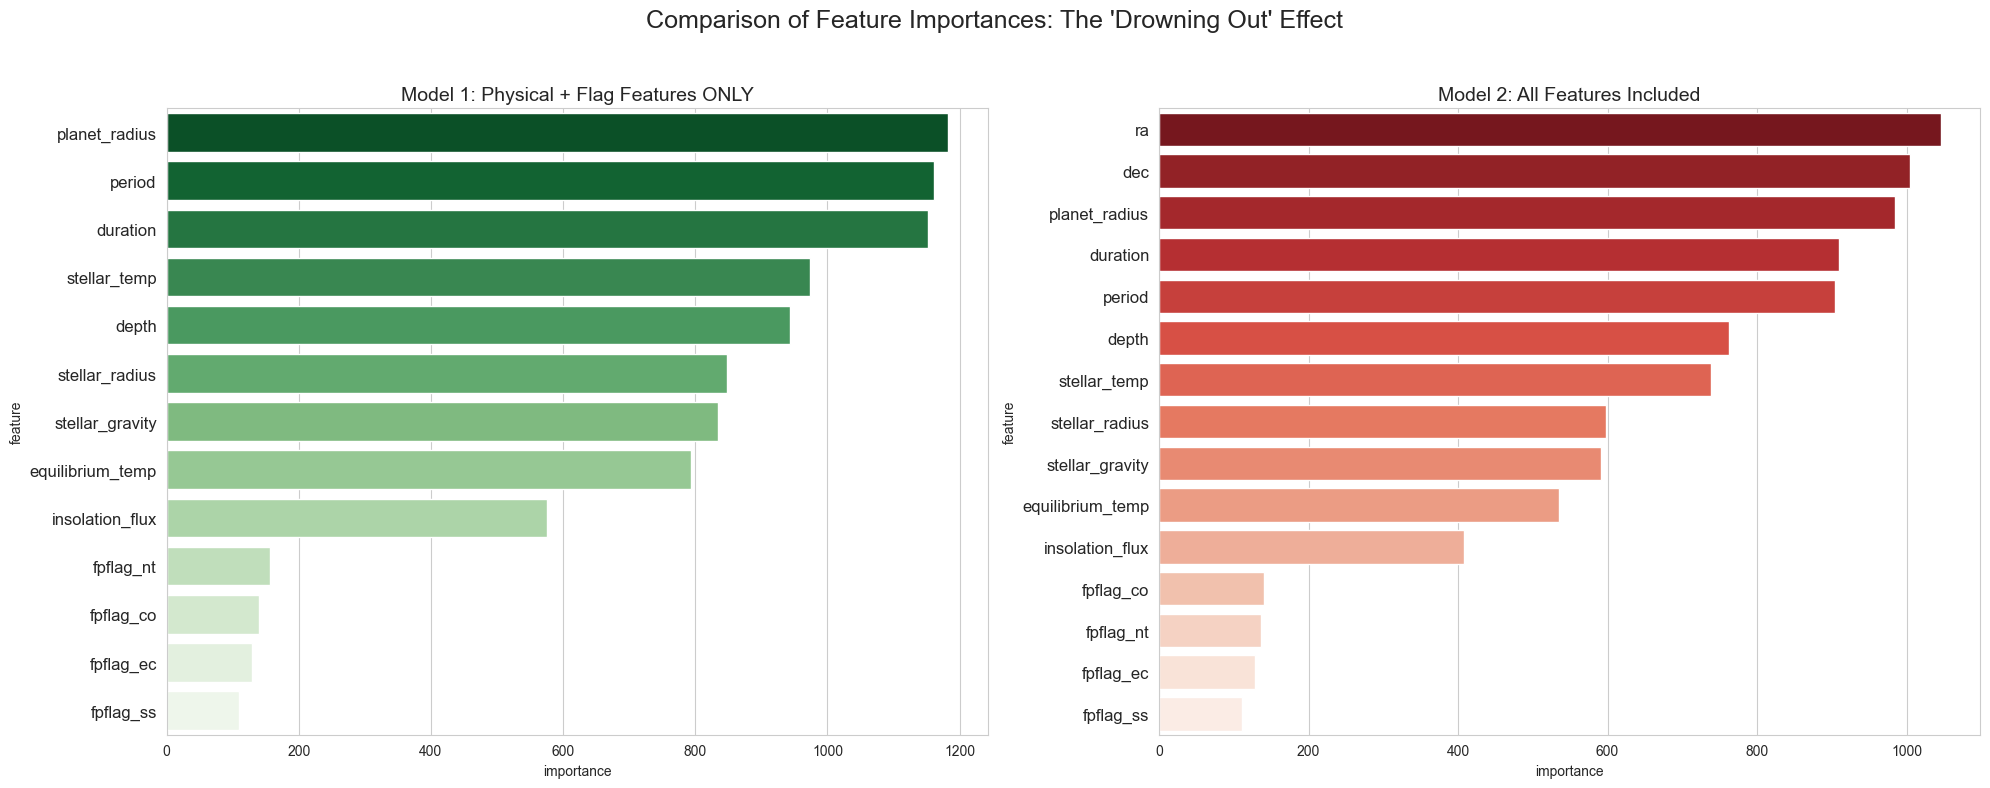


Interpretation: Compare the two charts. If the rank and importance of the 'fpflag_*' features are high on the left but drop significantly on the right, the 'drowning out' effect is proven.


In [10]:
print("\n--- EXPERIMENT 3: THE 'DROWNING OUT' EFFECT ANALYSIS ---")
print("Hypothesis: The presence of 'ra' and 'dec' actively suppresses the importance of the 'fpflag_*' features.")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Comparison of Feature Importances: The 'Drowning Out' Effect", fontsize=18)

# --- Model 1: The "Scientific" Model (Physical + Flags) ---
features1 = PHYSICAL_FEATURES + FLAG_FEATURES
X1 = X[features1]
model1 = lgb.LGBMClassifier(random_state=42).fit(X1, y)

importances1 = pd.DataFrame({'feature': model1.feature_name_, 'importance': model1.feature_importances_})
importances1 = importances1.sort_values('importance', ascending=False).head(15)

sns.barplot(ax=axes[0], x='importance', y='feature', data=importances1, palette='Greens_r')
axes[0].set_title('Model 1: Physical + Flag Features ONLY', fontsize=14)
axes[0].tick_params(axis='y', labelsize=12)


# --- Model 2: The "Kitchen Sink" Model (All Features) ---
features2 = PHYSICAL_FEATURES + FLAG_FEATURES + PROXY_FEATURES
X2 = X[features2]
model2 = lgb.LGBMClassifier(random_state=42).fit(X2, y)

importances2 = pd.DataFrame({'feature': model2.feature_name_, 'importance': model2.feature_importances_})
importances2 = importances2.sort_values('importance', ascending=False).head(15)

sns.barplot(ax=axes[1], x='importance', y='feature', data=importances2, palette='Reds_r')
axes[1].set_title('Model 2: All Features Included', fontsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nInterpretation: Compare the two charts. If the rank and importance of the 'fpflag_*' features are high on the left but drop significantly on the right, the 'drowning out' effect is proven.")